# Quantum Phase Estimation using `pytket` Boxes

When constructing circuits for quantum algorithms it is useful to think of higher level operations than just indiviudal quantum gates.

In `pytket` we can construct circuits using box structures which abstract away the complexity of the underlying circuit. This notebook is intended to complement the [boxes section](https://cqcl.github.io/pytket/manual/manual_circuit.html#boxes) of the user manual.

To demonstrate boxes in `pytket` we will consider the Quantum Phase Estimation algorithm (QPE). This is an important subroutine in several quantum algorithms including Shor's algorithm and fault-tolerant approaches to quantum chemistry.

## Overview of Phase Estimation

The Quantum Phase Estimation algorithm can be used to estimate the eigenvalues of some unitary operator $U$ to some desired precision.

The eigenvalues of $U$ lie on the unit circle, giving us the following eigenvalue equation

$$
\begin{equation}
U |\psi \rangle = e^{2 \pi i \theta} |\psi\rangle\,, \quad 0 \leq \theta \leq 1
\end{equation}
$$

Here $|\psi \rangle$ is an eigenstate of the operator $U$. In phase estimation we estimate the eigenvalue $e^{2 \pi i \theta}$ by approximating $\theta$. 


The circuit for Quantum phase estimation is itself composed of several subroutines which we can realise as boxes.

![](phase_est.png "Quantum Phase Estimation Circuit")

QPE is generally split up into three stages

1. Firstly we prepare an initial state in one register. In parallel we prepare a uniform superposition state using Hadamard gates on some ancilla qubits. The number of ancilla qubits determines how precisely we can estimate the phase $\theta$.

2. Secondly we apply successive controlled $U$ gates. This has the effect of "kicking back" phases onto the ancilla qubits according to the eigenvalue equation above.

3. Finally we apply the inverse Quantum Fourier Transform (QFT). This essentially plays the role of destructive interference, suppressing amplitudes from "undesirable states" and hopefully allowing us to measure a single outcome (or a small number of outcomes) with high probability.


There is some subtlety around the first point. The initial state used can be an exact eigenstate of $U$ however this may be difficult to prepare if we don't know the eigenvalues of  $U$ in advance. Alternatively we could use an initial state that is a linear combination of eigenstates, as the phase estimation will project into the eigenspace of $U$.

We also assume that we can implement $U$ with a quantum circuit. In chemistry applications $U$ could be of the form $U=e^{iHt}$ where $H$ is the Hamiltonian of some system of interest. In the cannonical algorithm, the number of controlled unitaries we apply scales exponentially with the number of ancilla qubits. This allows more precision at the expense of a larger quantum circuit. 

## The Quantum Fourier Transform

Before considering the other parts of the QPE algorithm, lets focus on the Quantum Fourier Transform (QFT) subroutine.

Mathematically, the QFT has the following action. 

\begin{equation}
QFT : |j\rangle\ \longmapsto \sum_{k=0}^{N - 1} e^{2 \pi ijk/N}|k\rangle, \quad N= 2^k
\end{equation}

This is essentially the Discrete Fourier transform except the input is a quantum state $|j\rangle$.

It is well known that the QFT can be implemented efficently with a quantum circuit

We can build the circuit for the $n$ qubit QFT using $n$ Hadamard gates $\frac{n}{2}$ swap gates and $\frac{n(n-1)}{2}$ controlled unitary rotations $\text{CU1}$.

$$
 \begin{equation}
 CU1(\phi) =
 \begin{pmatrix}
 I & 0 \\
 0 & U1(\phi)
 \end{pmatrix}
 \,, \quad
U1(\phi) =
 \begin{pmatrix}
 1 & 0 \\
 0 & e^{i \phi}
 \end{pmatrix}
 \end{equation}
$$

The circuit for the Quantum Fourier transform on three qubits is the following

![](qft.png "QFT Circuit")

We can build this circuit in `pytket` by adding gate operations manually:

In [1]:
from pytket.circuit import Circuit, OpType

# lets build the QFT for three qubits
qft3_circ = Circuit(3)

qft3_circ.H(0)
qft3_circ.add_gate(OpType.CU1 , [0.5], [1, 0])
qft3_circ.add_gate(OpType.CU1 , [0.25], [2, 0])

qft3_circ.H(1)
qft3_circ.add_gate(OpType.CU1 , [0.5], [2, 1])

qft3_circ.H(2)

qft3_circ.SWAP(0, 2)

[H q[0]; CU1(0.5) q[1], q[0]; CU1(0.25) q[2], q[0]; H q[1]; CU1(0.5) q[2], q[1]; H q[2]; SWAP q[0], q[2]; ]

In [2]:
from pytket.circuit.display import render_circuit_jupyter

render_circuit_jupyter(qft3_circ)

We can generalise the quantum Fourier transform to $n$ qubits by iterating over the qubits as follows

In [3]:
def build_qft_circuit(n_qubits: int) -> Circuit:
    circ = Circuit(n_qubits, name="QFT")
    q_counter = 0
    for j in range(n_qubits):
        circ.H(j)
        q_counter += 1
        for k in range(n_qubits - q_counter):
            circ.add_gate(OpType.CU1, 0.5 ** (k + 1), [k + q_counter, q_counter - 1])

    for i in range(0, n_qubits // 2):
        circ.SWAP(i, n_qubits - i - 1)

    return circ

In [4]:
qft4_circ: Circuit = build_qft_circuit(4)

render_circuit_jupyter(qft4_circ)

Now that we have the generalised circuit we can wrap it up in a `CircBox` which can then be added to another circuit as a subroutine.

In [5]:
from pytket.circuit import CircBox

qft4_box: CircBox = CircBox(qft4_circ)

qft_circ = Circuit(4).add_gate(qft4_box, [0, 1, 2, 3])

render_circuit_jupyter(qft_circ)

Note how the `CircBox` inherits the name `QFT` from the underlying circuit.

Recall that in our phase estimation algorithm we need to use the inverse QFT.

$$
\begin{equation}
\text{QFT}^† : \sum_{k=0}^{N - 1} e^{2 \pi ijk/N}|k\rangle \longmapsto |j\rangle\,, \quad N= 2^k
\end{equation}
$$


Now that we have the QFT circuit we can obtain the inverse by using `CircBox.dagger`. We can also verify that this is correct by inspecting the circuit inside with `CircBox.get_circuit()`.

In [6]:
inv_qft4_box = qft4_box.dagger

render_circuit_jupyter(inv_qft4_box.get_circuit())

## The Controlled Unitary Stage

Suppose that we had the following decomposition for $H$ in terms of Pauli strings $P_j$ and complex coefficents $\alpha_j$.

\begin{equation}
H = \sum_j \alpha_j P_j\,, \quad \, P_j \in \{I, X, Y, Z\}^{\otimes n}
\end{equation}

Here Pauli strings refers to tensor products of Pauli operators. These strings form an orthonormal basis for $2^n \times 2^n$ matrices.

Firstly we need to define our Hamiltonian. In `pytket` this can be done with the `QubitPauliOperator` class.

To define this object we use a python dictionary where the keys are the Pauli Strings $P_j$ and the values are the coefficents $\alpha_j$

As an example lets consider the operator.  

$$
\begin{equation}
H = \frac{1}{4} XXY + \frac{1}{7} ZXZ + \frac{1}{3} YYX
\end{equation}
$$

This is an artifical example. We will later consider a physically motivated Hamiltonain.

In [7]:
from pytket import Qubit
from pytket.pauli import Pauli, QubitPauliString
from pytket.utils import QubitPauliOperator

xxy = QubitPauliString({Qubit(0): Pauli.X, Qubit(1): Pauli.X, Qubit(2): Pauli.Y})
zxz = QubitPauliString({Qubit(0): Pauli.Z, Qubit(1): Pauli.X, Qubit(2): Pauli.Z})
yyx = QubitPauliString({Qubit(0): Pauli.Y, Qubit(1): Pauli.Y, Qubit(2): Pauli.X})

qpo = QubitPauliOperator({xxy: 1/4, zxz: 1/7, yyx: 1/3})

We can generate a circuit to approximate the unitary evolution of $e^{i H t}$ with the `gen_term_sequence_circuit` utility function.

In [8]:
from pytket.circuit import CircBox
from pytket.utils import gen_term_sequence_circuit

op_circ = gen_term_sequence_circuit(qpo, Circuit(3))
u_box = CircBox(op_circ)

We can create a controlled unitary $U$ with a `QControlBox` with $n$ controls. In phase estimation only a single control is needed so $n=1$.

In [9]:
from pytket.circuit import QControlBox

controlled_u = QControlBox(u_box, n=1)

In [10]:
test_circ = Circuit(4).add_gate(controlled_u, [0, 1, 2, 3])
render_circuit_jupyter(test_circ)

## Putting it all together

In [11]:
def build_phase_est_circuit(
    n_measurement_qubits: int, state_prep_circuit: Circuit, unitary_circuit: Circuit
) -> Circuit:
    
    qpe_circ: Circuit = Circuit()
    n_ancillas = state_prep_circuit.n_qubits
    measurement_register = qpe_circ.add_q_register("m", n_measurement_qubits)
    state_prep_register = qpe_circ.add_q_register("p", n_ancillas)

    qpe_circ.add_circuit(state_prep_circuit, list(state_prep_register))

    unitary_circuit.name = "U"
    controlled_u = QControlBox(CircBox(unitary_circuit), 1)

    # Add Hadamard gates to every qubit in the measurement register
    for m_qubit in measurement_register:
        qpe_circ.H(m_qubit)

    # Add all (2**n_measurement_qubits - 1) of the controlled unitaries sequentially
    for m_qubit in range(n_measurement_qubits):
        control_index = n_measurement_qubits - m_qubit - 1
        control_qubit = [measurement_register[control_index]]
        for _ in range(2**m_qubit):
            qpe_circ.add_qcontrolbox(
                controlled_u, control_qubit + list(state_prep_register)
            )

    # Finally, append the inverse qft and measure the qubits
    qft_box = CircBox(build_qft_circuit(n_measurement_qubits))
    inverse_qft_box = qft_box.dagger

    qpe_circ.add_circbox(inverse_qft_box, list(measurement_register))

    qpe_circ.measure_register(measurement_register, "c")

    return qpe_circ

## Phase Estimation with a Trivial Eigenstate

Lets test our circuit construction by preparing a trivial $|1\rangle $eigenstate of the $\text{U1}$ gate. We can then see if our phase estimation circuit returns the expected eigenvalue.

$$
\begin{equation}
U1(\phi)|1\rangle = e^{i\phi} = e^{2 \pi i \theta} \implies \theta = \frac{\phi}{2}
\end{equation}
$$

So we expect that our ideal phase $\theta$ will be half the input angle $\phi$ to our $U1$ gate.

In [12]:
state_prep_circuit = Circuit(1).X(0)

input_angle = 0.73 # angle as number of half turns

unitary_circuit = Circuit(1).add_gate(OpType.U1, [input_angle], [0])

In [13]:
qpe_circ_trivial = build_phase_est_circuit(4, state_prep_circuit=state_prep_circuit, unitary_circuit=unitary_circuit)

In [14]:
render_circuit_jupyter(qpe_circ_trivial)

Lets use the noiseless `AerBackend` simulator to run our phase estimation circuit.

In [15]:
from pytket.extensions.qiskit import AerBackend

backend = AerBackend()

compiled_circ = backend.get_compiled_circuit(qpe_circ_trivial)


n_shots = 1000
result = backend.run_circuit(compiled_circ, n_shots)

print(result.get_counts())

Counter({(0, 1, 1, 0): 923, (0, 1, 0, 1): 25, (0, 1, 1, 1): 18, (0, 1, 0, 0): 9, (1, 0, 0, 0): 7, (1, 0, 0, 1): 5, (0, 0, 1, 1): 4, (1, 0, 1, 1): 3, (1, 0, 1, 0): 2, (0, 0, 0, 0): 1, (0, 0, 1, 0): 1, (1, 1, 0, 1): 1, (1, 1, 1, 1): 1})


We can now plot our results. The plotting is imported from the `plotting.py` file.

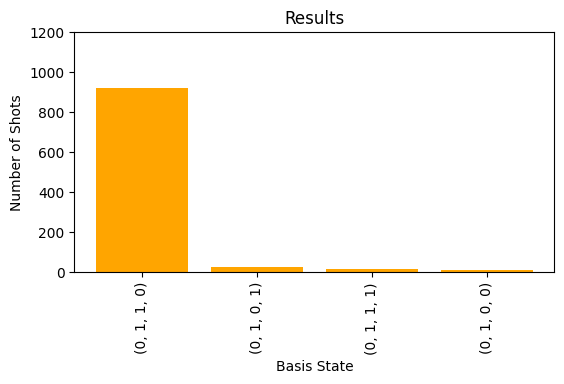

In [16]:
from plotting import plot_qpe_results

plot_qpe_results(result, y_limit=1.2*n_shots)

As expected we see one outcome with high probability. Lets now extract our approximation of $\theta$ from our output bitstrings.

suppose the $j$ is an integer representation of our most commonly measured bitstring.

$$
\begin{equation}
\theta_{estimate} = \frac{j}{N}
\end{equation}
$$

Here $N = 2 ^n$ where $n$ is the number of measurement qubits.

In [17]:
from pytket.backends.backendresult import BackendResult

def single_phase_from_backendresult(result: BackendResult) -> float:
    
    # Extract most common measurement outcome
    basis_state = result.get_counts().most_common()[0][0] 
    bitstring = "".join([str(bit) for bit in basis_state])
    
    # Calculate theta estimate
    n_measurement_qubits = len(bitstring)
    phase_estimate = int(bitstring, 2) / (2**n_measurement_qubits)
    
    return phase_estimate

In [18]:
theta = single_phase_from_backendresult(result)

In [19]:
print(theta)

0.375


In [20]:
print(input_angle / 2)

0.365


Our output is close to half our input angle $\phi$ as expected. Lets calculate our error.

In [21]:
error = round(abs(input_angle - (2 * theta)), 3) 
print(error)

0.02


## State Preparation

Lets now consider a more interesting Hamiltonian. We will look at the $H_2$ Hamiltonian for a bond length of 5 angstroms.

We can define the Hamiltonian as a `pytket` `QubitPauliOperator` and then synthesise a circuit for the time evolved Hamiltonian with the `gen_term_sequence_circuit` utility method.

Here we can load in our `QubitPauliOperator` from a JSON file.

In [22]:
import json
from pytket.utils import QubitPauliOperator

with open("h2_5A.json") as f:
  qpo_h25A = QubitPauliOperator.from_list(json.load(f))

In [23]:
ham_circ = gen_term_sequence_circuit(qpo_h25A, Circuit(4))

In [24]:
from pytket.passes import DecomposeBoxes

In [25]:
DecomposeBoxes().apply(ham_circ)

True

In [26]:
render_circuit_jupyter(ham_circ)

Now have to come up with an ansatz state to feed into our phase estimation algorithm.

We will use the following ansatz

$$
\begin{equation}
|\psi_0\rangle = e^{i \frac{\pi}{2}\theta YXXX}|1100\rangle\,.
\end{equation}
$$

We can synthesise a circuit for the Pauli exponential using `PauliExpBox`.

In [27]:
from pytket.pauli import Pauli
from pytket.circuit import PauliExpBox

state_circ = Circuit(4).X(0).X(1) 
yxxx =  [Pauli.Y, Pauli.X, Pauli.X, Pauli.X]       
yxxx_box = PauliExpBox(yxxx, 0.1) # here theta=0.1
state_circ.add_gate(yxxx_box, [0, 1, 2, 3])

[X q[0]; X q[1]; PauliExpBox q[0], q[1], q[2], q[3]; ]

we can extract the statevector for $e^{i \frac{\pi}{2}\theta YXXX}|1100\rangle$ using the `Circuit.get_statvector()` method.

In [28]:
initial_state = state_circ.get_statevector()

Finally we can prepare our initial state using `StatePreparationBox`.

In [29]:
from pytket.circuit import StatePreparationBox

state_prep_box = StatePreparationBox(initial_state)

We now have all of the ingredients we need to build our phase estimation circuit for the $H_2$ molecule. Here we will use 8 qubits to estimate the phase. 

Note that the number of controlled unitaries in our circuit will scale exponentially with the number of measurement qubits. Decomposing these controlled boxes to native gates can lead to very deep circuits.

We will again use the idealised `AerBackend` simulator for our simulation. If we were instead using a simulator with a noise model or a NISQ device we would expect our results to be degraded due to the large circuit depth.

In [30]:
ham_state_prep_circuit = Circuit(4).add_gate(state_prep_box, [0, 1, 2, 3])

In [31]:
h2_qpe_circuit = build_phase_est_circuit(8, state_prep_circuit=ham_state_prep_circuit, unitary_circuit=ham_circ)

In [32]:
render_circuit_jupyter(h2_qpe_circuit)

In [33]:
compiled_ham_circ = backend.get_compiled_circuit(h2_qpe_circuit, 0)

In [34]:
n_shots = 2000

ham_result = backend.run_circuit(compiled_ham_circ, n_shots=n_shots)

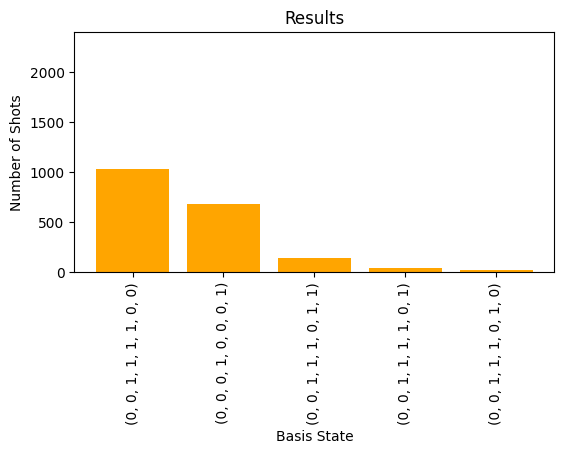

In [35]:
plot_qpe_results(ham_result, y_limit=1.2*n_shots, n_strings=5)